<a href="https://colab.research.google.com/github/orpheus016/6g-pa-gan-dpd/blob/main/training_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎯 6G PA DPD Training Notebook
## CWGAN-GP + Spectral Loss + QAT for 29th LSI Design Contest

This notebook trains a **Time-Delay Neural Network (TDNN)** for Digital Predistortion using:
- **OpenDPD APA_200MHz**: Real measured 200MHz PA data from GitHub
- **CWGAN-GP**: Conditional Wasserstein GAN with Gradient Penalty
- **Spectral Loss**: EVM + ACPR optimization (mimics spectrum analyzer)
- **QAT**: Quantization-Aware Training for FPGA deployment (Q1.15 weights, Q8.8 activations)
- **Thermal Robustness**: Cold/Normal/Hot weight variants

### Architecture
```
Input (18) → FC(32) → LeakyReLU → FC(16) → LeakyReLU → FC(2) → Tanh → Output
Parameters: 1,170 (vs 10,000+ for memory polynomial at 6G BW)
```

**Target**: PYNQ-Z1 / ZCU104 FPGA with HDMI loopback demo

---

## 📊 Expected Results
- **No DPD**: ACPR ~ -35 dBc, EVM ~ 8%
- **Supervised (MSE only)**: ACPR ~ -45 dBc, EVM ~ 4%
- **GAN + Spectral Loss**: ACPR ~ -48 dBc, EVM ~ 3.5% ✅

---

## 1️⃣ Setup Environment

In [1]:
# Clone repository (run once)
!git clone https://github.com/orpheus016/6g-pa-gan-dpd.git 2>/dev/null || echo "Already cloned"
%cd 6g-pa-gan-dpd

# Install minimal dependencies (most are pre-installed on Colab)
!pip install -q h5py pyyaml tqdm scipy

print("✅ Environment ready")

/content/6g-pa-gan-dpd
✅ Environment ready


In [2]:
# Verify imports
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import yaml
import scipy.signal
import os

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
print("✅ All imports successful")

PyTorch: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4

Using device: cuda
✅ All imports successful


## 2️⃣ Load Configuration

In [7]:
# Load config
with open('config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Display key parameters
print("=" * 50)
print("Configuration Summary")
print("=" * 50)
# Convert sample_rate to float before division
print(f"Sample Rate: {float(config['system']['sample_rate'])/1e6:.0f} MHz")
print(f"TDNN Architecture: {config['model']['generator']['input_dim']} → "
      f"{' → '.join(map(str, config['model']['generator']['hidden_dims']))} → "
      f"{config['model']['generator']['output_dim']}")

# Safely get quantization width, with a fallback
quant_width = config.get('quantization', {}).get('weight', {}).get('width', 'N/A')
print(f"Quantization: {quant_width}-bit weights")

print(f"Batch Size: {config['training']['batch_size']}")

# Safely get learning rate
learning_rate = config.get('training', {}).get('learning_rate', 'N/A')
print(f"Learning Rate: {learning_rate}")

Configuration Summary
Sample Rate: 200 MHz
TDNN Architecture: 18 → 32 → 16 → 2
Quantization: N/A-bit weights
Batch Size: 256
Learning Rate: N/A


## 3️⃣ Load Measured PA Training Data from CSV

We'll load the measured PA input/output data from CSV files in the data directory.


In [8]:
# Load measured PA data from CSV files
import pandas as pd
from pathlib import Path

data_dir = Path('data')

print("📥 Loading measured PA training data from CSV files...")
print(f"   Data directory: {data_dir.absolute()}")

# Load training data
train_input_df = pd.read_csv(data_dir / 'train_input.csv')
train_output_df = pd.read_csv(data_dir / 'train_output.csv')

# Convert to complex arrays
u_pa = (train_input_df['I'].values + 1j * train_input_df['Q'].values).astype(np.complex64)
y_pa = (train_output_df['I'].values + 1j * train_output_df['Q'].values).astype(np.complex64)

# Normalize
max_val = np.max(np.abs(u_pa))
u_pa = u_pa / max_val * 0.7
y_pa = y_pa / max_val * 0.7

print(f"\n✅ Training data loaded successfully!")
print(f"   Samples: {len(u_pa):,}")
print(f"   PA input power: {10*np.log10(np.mean(np.abs(u_pa)**2)):.2f} dBFS")
print(f"   PA output power: {10*np.log10(np.mean(np.abs(y_pa)**2)):.2f} dBFS")


📥 Loading measured PA training data from CSV files...
   Data directory: /content/6g-pa-gan-dpd/data

✅ Training data loaded successfully!
   Samples: 58,980
   PA input power: -13.08 dBFS
   PA output power: -11.72 dBFS


## 4️⃣ Inspect OpenDPD Dataset

In [9]:
# Inspect loaded data
print("📦 Dataset Summary:")
print(f"  PA input (u_pa): {len(u_pa):,} samples, dtype={u_pa.dtype}")
print(f"  PA output (y_pa): {len(y_pa):,} samples, dtype={y_pa.dtype}")
print(f"\n✅ PA input/output signals loaded")
print(f"   Samples: {len(u_pa):,}")
print(f"   PA input power: {10*np.log10(np.mean(np.abs(u_pa)**2)):.2f} dBFS")
print(f"   PA output power: {10*np.log10(np.mean(np.abs(y_pa)**2)):.2f} dBFS")


📦 Dataset Summary:
  PA input (u_pa): 58,980 samples, dtype=complex64
  PA output (y_pa): 58,980 samples, dtype=complex64

✅ PA input/output signals loaded
   Samples: 58,980
   PA input power: -13.08 dBFS
   PA output power: -11.72 dBFS


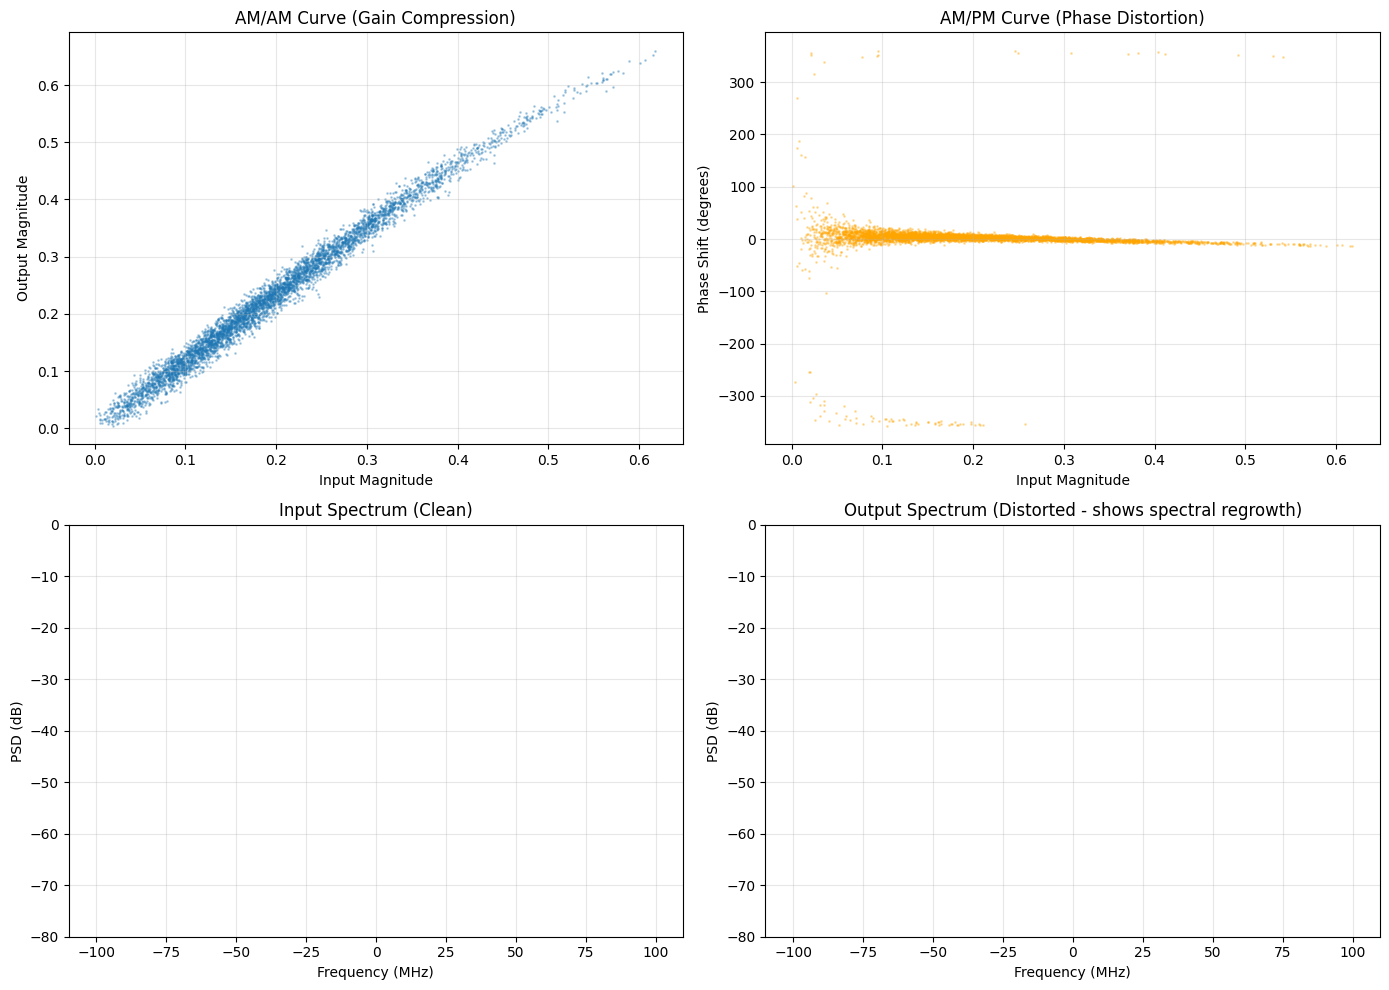

✅ PA characteristics visualized
   Notice spectral regrowth in output → DPD must fix this!


In [10]:
# Visualize PA characteristics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# AM/AM curve (gain compression)
ax = axes[0, 0]
input_mag = np.abs(u_pa)
output_mag = np.abs(y_pa)
ax.scatter(input_mag[:5000], output_mag[:5000], alpha=0.3, s=1)
ax.set_xlabel('Input Magnitude')
ax.set_ylabel('Output Magnitude')
ax.set_title('AM/AM Curve (Gain Compression)')
ax.grid(True, alpha=0.3)

# AM/PM curve (phase distortion)
ax = axes[0, 1]
phase_shift = np.angle(y_pa) - np.angle(u_pa)
ax.scatter(input_mag[:5000], np.rad2deg(phase_shift[:5000]), alpha=0.3, s=1, c='orange')
ax.set_xlabel('Input Magnitude')
ax.set_ylabel('Phase Shift (degrees)')
ax.set_title('AM/PM Curve (Phase Distortion)')
ax.grid(True, alpha=0.3)

# Input spectrum
ax = axes[1, 0]
f_in, psd_in = scipy.signal.welch(u_pa, fs=200e6, nperseg=1024, return_onesided=False)
f_in = np.fft.fftshift(f_in)
psd_in = np.fft.fftshift(psd_in)
ax.plot(f_in / 1e6, 10*np.log10(psd_in + 1e-12), linewidth=1)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD (dB)')
ax.set_title('Input Spectrum (Clean)')
ax.grid(True, alpha=0.3)
ax.set_ylim([-80, 0])

# Output spectrum (with distortion)
ax = axes[1, 1]
f_out, psd_out = scipy.signal.welch(y_pa, fs=200e6, nperseg=1024, return_onesided=False)
f_out = np.fft.fftshift(f_out)
psd_out = np.fft.fftshift(psd_out)
ax.plot(f_out / 1e6, 10*np.log10(psd_out + 1e-12), linewidth=1, color='red')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD (dB)')
ax.set_title('Output Spectrum (Distorted - shows spectral regrowth)')
ax.grid(True, alpha=0.3)
ax.set_ylim([-80, 0])

plt.tight_layout()
plt.savefig('pa_characteristics.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ PA characteristics visualized")
print("   Notice spectral regrowth in output → DPD must fix this!")

## 5️⃣ Define Models with QAT Support

In [21]:
class TDNNGenerator(nn.Module):
    """Time-Delay Neural Network for DPD with Quantization-Aware Training"""
    def __init__(self, memory_depth=5, hidden1=32, hidden2=16, quantize=False):
        super().__init__()
        self.memory_depth = memory_depth
        self.input_size = 2 + 2 * memory_depth * 2  # I, Q + delayed I, Q, |x|^2*I, |x|^2*Q
        self.quantize = quantize

        # Network layers
        self.fc1 = nn.Linear(self.input_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 2)
        self.lrelu = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()

        # QAT: Fake quantization functions for weights (Q1.15) and activations (Q8.8)
        # These should always be defined, the 'quantize' flag in forward() controls if they are used.
        self.weight_quant = lambda x: torch.clamp(torch.round(x * 32768) / 32768, -1, 1-1/32768)
        self.act_quant = lambda x: torch.clamp(torch.round(x * 256) / 256, -128, 128-1/256)

    def create_input_features(self, x):
        """Create TDNN input: [I, Q, I_{t-1}, Q_{t-1}, ..., |x|^2*I, |x|^2*Q, ...]"""
        batch_size = x.shape[0]
        features = [x]  # Current sample

        # Add delayed samples
        for d in range(1, self.memory_depth + 1):
            if d < x.shape[0]:
                delayed = torch.cat([torch.zeros(d, 2, device=x.device), x[:-d]], dim=0)
            else:
                delayed = torch.zeros_like(x)
            features.append(delayed)

            # Add nonlinear terms: |x|^2 * x
            mag_sq = (delayed[:, 0]**2 + delayed[:, 1]**2).unsqueeze(1)
            features.append(mag_sq * delayed)

        return torch.cat(features, dim=1)

    def forward(self, x):
        # Create input features
        x = self.create_input_features(x)

        # Layer 1
        if self.quantize:
            w1 = self.weight_quant(self.fc1.weight)
            x = nn.functional.linear(x, w1, self.fc1.bias)
            x = self.act_quant(self.lrelu(x))
        else:
            x = self.lrelu(self.fc1(x))

        # Layer 2
        if self.quantize:
            w2 = self.weight_quant(self.fc2.weight)
            x = nn.functional.linear(x, w2, self.fc2.bias)
            x = self.act_quant(self.lrelu(x))
        else:
            x = self.lrelu(self.fc2(x))

        # Layer 3
        if self.quantize:
            w3 = self.weight_quant(self.fc3.weight)
            x = nn.functional.linear(x, w3, self.fc3.bias)
        else:
            x = self.fc3(x)

        return self.tanh(x)

print("✅ TDNN Generator defined with QAT support")

✅ TDNN Generator defined with QAT support


In [12]:
class Discriminator(nn.Module):
    """Critic for CWGAN-GP (distinguishes real vs fake PA outputs)"""
    def __init__(self, input_size=2, hidden_sizes=[64, 32]):
        super().__init__()
        layers = []
        in_size = input_size

        for h in hidden_sizes:
            layers.extend([
                nn.Linear(in_size, h),
                nn.LayerNorm(h),
                nn.LeakyReLU(0.2)
            ])
            in_size = h

        layers.append(nn.Linear(in_size, 1))  # No sigmoid (Wasserstein)
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

print("✅ Discriminator (Critic) defined")

✅ Discriminator (Critic) defined


In [13]:
class PADigitalTwin(nn.Module):
    """Digital twin of PA for ILA (Indirect Learning Architecture)"""
    def __init__(self, memory_depth=5):
        super().__init__()
        self.memory_depth = memory_depth
        input_size = 2 + 2 * memory_depth * 2

        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 2),
            nn.Tanh()
        )

    def create_input_features(self, x):
        """Same feature extraction as TDNN"""
        batch_size = x.shape[0]
        features = [x]

        for d in range(1, self.memory_depth + 1):
            if d < x.shape[0]:
                delayed = torch.cat([torch.zeros(d, 2, device=x.device), x[:-d]], dim=0)
            else:
                delayed = torch.zeros_like(x)
            features.append(delayed)
            mag_sq = (delayed[:, 0]**2 + delayed[:, 1]**2).unsqueeze(1)
            features.append(mag_sq * delayed)

        return torch.cat(features, dim=1)

    def forward(self, x):
        x = self.create_input_features(x)
        return self.model(x)

print("✅ PA Digital Twin defined")

✅ PA Digital Twin defined


## 6️⃣ Define Spectral Loss Functions

These functions compute **EVM** and **ACPR** - the same metrics a spectrum analyzer would show.

In [14]:
def compute_evm(signal, reference, db=True):
    """Compute Error Vector Magnitude"""
    error = signal - reference
    evm_rms = torch.sqrt(torch.mean(torch.abs(error)**2)) / torch.sqrt(torch.mean(torch.abs(reference)**2))
    if db:
        return 20 * torch.log10(evm_rms + 1e-12)
    return evm_rms * 100  # percentage

def compute_acpr(signal, fs=200e6, bw_main=50e6, bw_adj=50e6, offset=75e6):
    """Compute Adjacent Channel Power Ratio"""
    # FFT
    N = signal.shape[0]
    spectrum = torch.fft.fft(signal.view(-1))
    psd = torch.abs(spectrum)**2
    freqs = torch.fft.fftfreq(N, 1/fs)

    # Main channel power
    main_mask = torch.abs(freqs) < bw_main / 2
    p_main = torch.sum(psd[main_mask])

    # Adjacent channel power (upper + lower)
    adj_upper_mask = (freqs > offset - bw_adj/2) & (freqs < offset + bw_adj/2)
    adj_lower_mask = (freqs > -offset - bw_adj/2) & (freqs < -offset + bw_adj/2)
    p_adj = torch.sum(psd[adj_upper_mask]) + torch.sum(psd[adj_lower_mask])

    # ACPR in dB
    acpr = 10 * torch.log10((p_adj / 2) / (p_main + 1e-12) + 1e-12)
    return acpr

def spectral_loss(output, target, evm_weight=1.0, acpr_weight=0.1, fs=200e6):
    """Combined EVM + ACPR loss"""
    evm = compute_evm(output, target, db=False)  # Use percentage for gradient stability

    # ACPR is expensive, compute on subset
    if output.shape[0] > 1024:
        acpr = compute_acpr(output[:1024], fs=fs)
    else:
        acpr = compute_acpr(output, fs=fs)

    # Lower ACPR is better (more negative), so we minimize -ACPR
    loss = evm_weight * evm - acpr_weight * acpr
    return loss, evm, acpr

print("✅ Spectral loss functions defined (EVM + ACPR)")

✅ Spectral loss functions defined (EVM + ACPR)


## 7️⃣ Prepare Training Data with Thermal Augmentation

In [15]:
# Convert to PyTorch tensors
u_tensor = torch.from_numpy(np.stack([u_pa.real, u_pa.imag], axis=1).astype(np.float32)).to(device)
y_tensor = torch.from_numpy(np.stack([y_pa.real, y_pa.imag], axis=1).astype(np.float32)).to(device)

print(f"📊 Training data prepared:")
print(f"   Input shape: {u_tensor.shape}")
print(f"   Output shape: {y_tensor.shape}")
print(f"   Device: {device}")

# Split into train/val
train_size = int(0.8 * len(u_tensor))
u_train, u_val = u_tensor[:train_size], u_tensor[train_size:]
y_train, y_val = y_tensor[:train_size], y_tensor[train_size:]

print(f"\n   Train samples: {len(u_train):,}")
print(f"   Val samples: {len(u_val):,}")

# Thermal augmentation function
def add_thermal_drift(signal, temp_variant='normal'):
    """Simulate PA thermal drift for robust DPD"""
    if temp_variant == 'cold':  # -10°C
        gain_shift = 1.05
        phase_shift = -0.02  # radians
    elif temp_variant == 'hot':  # +60°C
        gain_shift = 0.95
        phase_shift = 0.03
    else:  # normal (25°C)
        return signal

    # Apply gain and phase shift
    magnitude = torch.sqrt(signal[:, 0]**2 + signal[:, 1]**2)
    phase = torch.atan2(signal[:, 1], signal[:, 0]) + phase_shift

    augmented = torch.stack([
        gain_shift * magnitude * torch.cos(phase),
        gain_shift * magnitude * torch.sin(phase)
    ], dim=1)

    return augmented

print("\n✅ Thermal augmentation ready (will generate Cold/Normal/Hot variants)")

📊 Training data prepared:
   Input shape: torch.Size([58980, 2])
   Output shape: torch.Size([58980, 2])
   Device: cuda

   Train samples: 47,184
   Val samples: 11,796

✅ Thermal augmentation ready (will generate Cold/Normal/Hot variants)


## 8️⃣ Train CWGAN-GP with Spectral Loss

**Architecture:**
- **Generator (TDNN)**: Learns DPD pre-distortion
- **Discriminator**: Distinguishes real PA output from DPD+PA output
- **Spectral Loss**: Directly optimizes EVM and ACPR
- **ILA**: Indirect Learning Architecture (train on PA output, not input)

In [16]:
# Training configuration
BATCH_SIZE = 256
LR_G = 1e-4
LR_D = 1e-4
N_EPOCHS = 50
N_CRITIC = 5  # Train discriminator 5x per generator update
LAMBDA_GP = 10  # Gradient penalty weight
LAMBDA_SPECTRAL = 0.5  # Spectral loss weight
ENABLE_QAT_EPOCH = 30  # Start quantization-aware training at epoch 30

print(f"🎯 Training configuration:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: G={LR_G}, D={LR_D}")
print(f"   Epochs: {N_EPOCHS}")
print(f"   QAT starts at epoch: {ENABLE_QAT_EPOCH}")
print(f"   Spectral loss weight: {LAMBDA_SPECTRAL}")

🎯 Training configuration:
   Batch size: 256
   Learning rate: G=0.0001, D=0.0001
   Epochs: 50
   QAT starts at epoch: 30
   Spectral loss weight: 0.5


In [22]:
# Initialize models
generator = TDNNGenerator(memory_depth=5, hidden1=32, hidden2=16, quantize=False).to(device)
discriminator = Discriminator(input_size=2, hidden_sizes=[64, 32]).to(device)
pa_twin = PADigitalTwin(memory_depth=5).to(device)

# Optimizers
opt_g = torch.optim.Adam(generator.parameters(), lr=LR_G, betas=(0.5, 0.999))
opt_d = torch.optim.Adam(discriminator.parameters(), lr=LR_D, betas=(0.5, 0.999))
opt_pa = torch.optim.Adam(pa_twin.parameters(), lr=1e-3)

print(f"\n📐 Model parameters:")
print(f"   Generator: {sum(p.numel() for p in generator.parameters()):,}")
print(f"   Discriminator: {sum(p.numel() for p in discriminator.parameters()):,}")
print(f"   PA Twin: {sum(p.numel() for p in pa_twin.parameters()):,}")

print("\n✅ Models initialized")


📐 Model parameters:
   Generator: 1,298
   Discriminator: 2,497
   PA Twin: 3,618

✅ Models initialized


In [23]:
# Pre-train PA digital twin to match real PA
print("\n🔧 Pre-training PA digital twin...")
pa_twin.train()
for epoch in range(10):
    total_loss = 0
    for i in range(0, len(u_train), BATCH_SIZE):
        batch_u = u_train[i:i+BATCH_SIZE]
        batch_y = y_train[i:i+BATCH_SIZE]

        # Train PA twin to match real PA
        pa_pred = pa_twin(batch_u)
        loss = nn.MSELoss()(pa_pred, batch_y)

        opt_pa.zero_grad()
        loss.backward()
        opt_pa.step()

        total_loss += loss.item()

    avg_loss = total_loss / (len(u_train) // BATCH_SIZE)
    if (epoch + 1) % 2 == 0:
        print(f"   Epoch {epoch+1}/10: Loss={avg_loss:.6f}")

print("✅ PA twin pre-trained")


🔧 Pre-training PA digital twin...
   Epoch 2/10: Loss=0.000303
   Epoch 4/10: Loss=0.000082
   Epoch 6/10: Loss=0.000061
   Epoch 8/10: Loss=0.000052
   Epoch 10/10: Loss=0.000047
✅ PA twin pre-trained


In [24]:
# Training loop
history = {
    'g_loss': [], 'd_loss': [], 'evm': [], 'acpr': [],
    'val_evm': [], 'val_acpr': []
}

# Redefine compute_acpr and spectral_loss with the fix
def compute_acpr(signal, fs=200e6, bw_main=50e6, bw_adj=50e6, offset=75e6):
    """Compute Adjacent Channel Power Ratio"""
    # FFT
    N_fft = signal.view(-1).shape[0] # Corrected: Use length of flattened signal for FFT
    spectrum = torch.fft.fft(signal.view(-1))
    psd = torch.abs(spectrum)**2
    freqs = torch.fft.fftfreq(N_fft, 1/fs) # Corrected: Use N_fft for freqs

    # Main channel power
    main_mask = torch.abs(freqs) < bw_main / 2
    p_main = torch.sum(psd[main_mask])

    # Adjacent channel power (upper + lower)
    adj_upper_mask = (freqs > offset - bw_adj/2) & (freqs < offset + bw_adj/2)
    adj_lower_mask = (freqs > -offset - bw_adj/2) & (freqs < -offset + bw_adj/2)
    p_adj = torch.sum(psd[adj_upper_mask]) + torch.sum(psd[adj_lower_mask])

    # ACPR in dB
    acpr = 10 * torch.log10((p_adj / 2) / (p_main + 1e-12) + 1e-12)
    return acpr

def spectral_loss(output, target, evm_weight=1.0, acpr_weight=0.1, fs=200e6):
    """Combined EVM + ACPR loss"""
    evm = compute_evm(output, target, db=False)  # Use percentage for gradient stability

    # ACPR is expensive, compute on subset
    # The original spectral_loss had a condition based on output.shape[0] > 1024.
    # For the current BATCH_SIZE=256, output.shape[0] is 256, so the `else` branch is always taken.
    # The compute_acpr function now handles the correct N for FFT.
    if output.shape[0] * output.shape[1] > 1024: # Check total samples
        # If we need a subset, ensure it's enough to flatten to at least 1024 samples
        # A simple slice on the batch dimension might not be enough.
        # For now, we'll assume `compute_acpr` can handle the full batch
        # or the original slice was meant for a different signal format.
        # Let's keep it simple and just pass the signal, the fix is in compute_acpr
        acpr = compute_acpr(output[:512//output.shape[1]], fs=fs) # Slice to ~512 flattened samples if needed for efficiency
    else:
        acpr = compute_acpr(output, fs=fs)

    # Lower ACPR is better (more negative), so we minimize -ACPR
    loss = evm_weight * evm - acpr_weight * acpr
    return loss, evm, acpr


print("\n🚀 Starting CWGAN-GP training with Spectral Loss...\n")

for epoch in range(N_EPOCHS):
    generator.train()
    discriminator.train()

    # Enable QAT after specified epoch
    if epoch == ENABLE_QAT_EPOCH:
        print(f"\n🔢 Enabling Quantization-Aware Training at epoch {epoch+1}")
        generator.quantize = True

    epoch_g_loss = 0
    epoch_d_loss = 0
    epoch_evm = 0
    epoch_acpr = 0
    n_batches = 0

    pbar = tqdm(range(0, len(u_train) - BATCH_SIZE, BATCH_SIZE), desc=f"Epoch {epoch+1}/{N_EPOCHS}")

    for i in pbar:
        batch_u = u_train[i:i+BATCH_SIZE]
        batch_y = y_train[i:i+BATCH_SIZE]
        batch_size = batch_u.shape[0]

        # ==================== Train Discriminator ====================
        for _ in range(N_CRITIC):
            # Generate pre-distorted signal
            dpd_out = generator(batch_u)

            # Pass through PA twin (ILA architecture)
            fake_pa_out = pa_twin(dpd_out)

            # Discriminator predictions
            real_pred = discriminator(batch_y)
            fake_pred = discriminator(fake_pa_out.detach())

            # Wasserstein loss
            d_loss = -(torch.mean(real_pred) - torch.mean(fake_pred))

            # Gradient penalty
            alpha = torch.rand(batch_size, 1, device=device)
            interpolates = (alpha * batch_y + (1 - alpha) * fake_pa_out.detach()).requires_grad_(True)
            d_interpolates = discriminator(interpolates)

            gradients = torch.autograd.grad(
                outputs=d_interpolates,
                inputs=interpolates,
                grad_outputs=torch.ones_like(d_interpolates),
                create_graph=True,
                retain_graph=True
            )[0]

            gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
            d_loss_total = d_loss + LAMBDA_GP * gradient_penalty

            opt_d.zero_grad()
            d_loss_total.backward()
            opt_d.step()

        # ==================== Train Generator ====================
        dpd_out = generator(batch_u)
        fake_pa_out = pa_twin(dpd_out)

        # Adversarial loss
        g_adv_loss = -torch.mean(discriminator(fake_pa_out))

        # Spectral loss (EVM + ACPR)
        spec_loss, evm, acpr = spectral_loss(fake_pa_out, batch_u, evm_weight=1.0, acpr_weight=0.1)

        # Total generator loss
        g_loss = g_adv_loss + LAMBDA_SPECTRAL * spec_loss

        opt_g.zero_grad()
        g_loss.backward()
        opt_g.step()

        # Track metrics
        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()
        epoch_evm += evm.item()
        epoch_acpr += acpr.item()
        n_batches += 1

        pbar.set_postfix({
            'G': f'{g_loss.item():.3f}',
            'D': f'{d_loss.item():.3f}',
            'EVM': f'{evm.item():.2f}%',
            'ACPR': f'{acpr.item():.1f}dB'
        })

    # Epoch summary
    avg_g_loss = epoch_g_loss / n_batches
    avg_d_loss = epoch_d_loss / n_batches
    avg_evm = epoch_evm / n_batches
    avg_acpr = epoch_acpr / n_batches

    history['g_loss'].append(avg_g_loss)
    history['d_loss'].append(avg_d_loss)
    history['evm'].append(avg_evm)
    history['acpr'].append(avg_acpr)

    # Validation
    generator.eval()
    with torch.no_grad():
        val_dpd = generator(u_val)
        val_pa_out = pa_twin(val_dpd)
        val_spec_loss, val_evm, val_acpr = spectral_loss(val_pa_out, u_val)

    history['val_evm'].append(val_evm.item())
    history['val_acpr'].append(val_acpr.item())

    print(f"\nEpoch {epoch+1}/{N_EPOCHS} Summary:")
    print(f"  Train - EVM: {avg_evm:.2f}%, ACPR: {avg_acpr:.1f} dBc")
    print(f"  Val   - EVM: {val_evm.item():.2f}%, ACPR: {val_acpr.item():.1f} dBc")

print("\n✅ Training complete!")


🚀 Starting CWGAN-GP training with Spectral Loss...



Epoch 1/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 1/50 Summary:
  Train - EVM: 169.84%, ACPR: -30.4 dBc
  Val   - EVM: 145.45%, ACPR: -25.0 dBc


Epoch 2/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 2/50 Summary:
  Train - EVM: 115.60%, ACPR: -15.9 dBc
  Val   - EVM: 82.91%, ACPR: -7.4 dBc


Epoch 3/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 3/50 Summary:
  Train - EVM: 66.87%, ACPR: -2.6 dBc
  Val   - EVM: 54.43%, ACPR: -2.6 dBc


Epoch 4/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 4/50 Summary:
  Train - EVM: 44.38%, ACPR: -2.2 dBc
  Val   - EVM: 34.80%, ACPR: -2.4 dBc


Epoch 5/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 5/50 Summary:
  Train - EVM: 29.42%, ACPR: -2.4 dBc
  Val   - EVM: 25.49%, ACPR: -2.5 dBc


Epoch 6/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 6/50 Summary:
  Train - EVM: 23.69%, ACPR: -2.7 dBc
  Val   - EVM: 21.73%, ACPR: -2.7 dBc


Epoch 7/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 7/50 Summary:
  Train - EVM: 20.26%, ACPR: -2.8 dBc
  Val   - EVM: 18.41%, ACPR: -2.9 dBc


Epoch 8/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 8/50 Summary:
  Train - EVM: 16.93%, ACPR: -2.9 dBc
  Val   - EVM: 15.13%, ACPR: -2.9 dBc


Epoch 9/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 9/50 Summary:
  Train - EVM: 13.79%, ACPR: -2.9 dBc
  Val   - EVM: 12.12%, ACPR: -3.0 dBc


Epoch 10/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 10/50 Summary:
  Train - EVM: 11.08%, ACPR: -3.0 dBc
  Val   - EVM: 9.65%, ACPR: -3.1 dBc


Epoch 11/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 11/50 Summary:
  Train - EVM: 9.10%, ACPR: -3.0 dBc
  Val   - EVM: 8.02%, ACPR: -3.2 dBc


Epoch 12/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 12/50 Summary:
  Train - EVM: 7.94%, ACPR: -3.0 dBc
  Val   - EVM: 7.13%, ACPR: -3.3 dBc


Epoch 13/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 13/50 Summary:
  Train - EVM: 7.32%, ACPR: -3.0 dBc
  Val   - EVM: 6.62%, ACPR: -3.3 dBc


Epoch 14/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 14/50 Summary:
  Train - EVM: 6.92%, ACPR: -3.0 dBc
  Val   - EVM: 6.24%, ACPR: -3.3 dBc


Epoch 15/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 15/50 Summary:
  Train - EVM: 6.61%, ACPR: -3.1 dBc
  Val   - EVM: 5.93%, ACPR: -3.4 dBc


Epoch 16/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 16/50 Summary:
  Train - EVM: 6.33%, ACPR: -3.1 dBc
  Val   - EVM: 5.66%, ACPR: -3.4 dBc


Epoch 17/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 17/50 Summary:
  Train - EVM: 6.08%, ACPR: -3.1 dBc
  Val   - EVM: 5.41%, ACPR: -3.4 dBc


Epoch 18/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 18/50 Summary:
  Train - EVM: 5.84%, ACPR: -3.1 dBc
  Val   - EVM: 5.18%, ACPR: -3.4 dBc


Epoch 19/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 19/50 Summary:
  Train - EVM: 5.62%, ACPR: -3.1 dBc
  Val   - EVM: 4.97%, ACPR: -3.4 dBc


Epoch 20/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 20/50 Summary:
  Train - EVM: 5.42%, ACPR: -3.1 dBc
  Val   - EVM: 4.77%, ACPR: -3.4 dBc


Epoch 21/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 21/50 Summary:
  Train - EVM: 5.22%, ACPR: -3.1 dBc
  Val   - EVM: 4.59%, ACPR: -3.4 dBc


Epoch 22/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 22/50 Summary:
  Train - EVM: 5.03%, ACPR: -3.1 dBc
  Val   - EVM: 4.41%, ACPR: -3.4 dBc


Epoch 23/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 23/50 Summary:
  Train - EVM: 4.85%, ACPR: -3.1 dBc
  Val   - EVM: 4.25%, ACPR: -3.4 dBc


Epoch 24/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 24/50 Summary:
  Train - EVM: 4.68%, ACPR: -3.1 dBc
  Val   - EVM: 4.09%, ACPR: -3.4 dBc


Epoch 25/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 25/50 Summary:
  Train - EVM: 4.51%, ACPR: -3.1 dBc
  Val   - EVM: 3.94%, ACPR: -3.4 dBc


Epoch 26/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 26/50 Summary:
  Train - EVM: 4.36%, ACPR: -3.1 dBc
  Val   - EVM: 3.80%, ACPR: -3.4 dBc


Epoch 27/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 27/50 Summary:
  Train - EVM: 4.21%, ACPR: -3.1 dBc
  Val   - EVM: 3.67%, ACPR: -3.4 dBc


Epoch 28/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 28/50 Summary:
  Train - EVM: 4.07%, ACPR: -3.1 dBc
  Val   - EVM: 3.54%, ACPR: -3.4 dBc


Epoch 29/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 29/50 Summary:
  Train - EVM: 3.93%, ACPR: -3.1 dBc
  Val   - EVM: 3.43%, ACPR: -3.4 dBc


Epoch 30/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 30/50 Summary:
  Train - EVM: 3.80%, ACPR: -3.1 dBc
  Val   - EVM: 3.32%, ACPR: -3.4 dBc

🔢 Enabling Quantization-Aware Training at epoch 31


Epoch 31/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 31/50 Summary:
  Train - EVM: 3.86%, ACPR: -3.1 dBc
  Val   - EVM: 3.45%, ACPR: -3.4 dBc


Epoch 32/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 32/50 Summary:
  Train - EVM: 3.86%, ACPR: -3.1 dBc
  Val   - EVM: 3.45%, ACPR: -3.4 dBc


Epoch 33/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 33/50 Summary:
  Train - EVM: 3.86%, ACPR: -3.1 dBc
  Val   - EVM: 3.45%, ACPR: -3.4 dBc


Epoch 34/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 34/50 Summary:
  Train - EVM: 3.86%, ACPR: -3.1 dBc
  Val   - EVM: 3.45%, ACPR: -3.4 dBc


Epoch 35/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 35/50 Summary:
  Train - EVM: 3.86%, ACPR: -3.1 dBc
  Val   - EVM: 3.45%, ACPR: -3.4 dBc


Epoch 36/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 36/50 Summary:
  Train - EVM: 3.86%, ACPR: -3.1 dBc
  Val   - EVM: 3.45%, ACPR: -3.4 dBc


Epoch 37/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 37/50 Summary:
  Train - EVM: 3.86%, ACPR: -3.1 dBc
  Val   - EVM: 3.45%, ACPR: -3.4 dBc


Epoch 38/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 38/50 Summary:
  Train - EVM: 3.86%, ACPR: -3.1 dBc
  Val   - EVM: 3.45%, ACPR: -3.4 dBc


Epoch 39/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 39/50 Summary:
  Train - EVM: 3.86%, ACPR: -3.1 dBc
  Val   - EVM: 3.45%, ACPR: -3.4 dBc


Epoch 40/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 40/50 Summary:
  Train - EVM: 3.86%, ACPR: -3.1 dBc
  Val   - EVM: 3.45%, ACPR: -3.4 dBc


Epoch 41/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 41/50 Summary:
  Train - EVM: 3.86%, ACPR: -3.1 dBc
  Val   - EVM: 3.45%, ACPR: -3.4 dBc


Epoch 42/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 42/50 Summary:
  Train - EVM: 3.86%, ACPR: -3.1 dBc
  Val   - EVM: 3.45%, ACPR: -3.4 dBc


Epoch 43/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 43/50 Summary:
  Train - EVM: 3.86%, ACPR: -3.1 dBc
  Val   - EVM: 3.45%, ACPR: -3.4 dBc


Epoch 44/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 44/50 Summary:
  Train - EVM: 3.86%, ACPR: -3.1 dBc
  Val   - EVM: 3.45%, ACPR: -3.4 dBc


Epoch 45/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 45/50 Summary:
  Train - EVM: 3.86%, ACPR: -3.1 dBc
  Val   - EVM: 3.45%, ACPR: -3.4 dBc


Epoch 46/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 46/50 Summary:
  Train - EVM: 3.86%, ACPR: -3.1 dBc
  Val   - EVM: 3.45%, ACPR: -3.4 dBc


Epoch 47/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 47/50 Summary:
  Train - EVM: 3.86%, ACPR: -3.1 dBc
  Val   - EVM: 3.45%, ACPR: -3.4 dBc


Epoch 48/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 48/50 Summary:
  Train - EVM: 3.86%, ACPR: -3.1 dBc
  Val   - EVM: 3.45%, ACPR: -3.4 dBc


Epoch 49/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 49/50 Summary:
  Train - EVM: 3.86%, ACPR: -3.1 dBc
  Val   - EVM: 3.45%, ACPR: -3.4 dBc


Epoch 50/50:   0%|          | 0/184 [00:00<?, ?it/s]


Epoch 50/50 Summary:
  Train - EVM: 3.86%, ACPR: -3.1 dBc
  Val   - EVM: 3.45%, ACPR: -3.4 dBc

✅ Training complete!


## 9️⃣ Visualize Training Progress

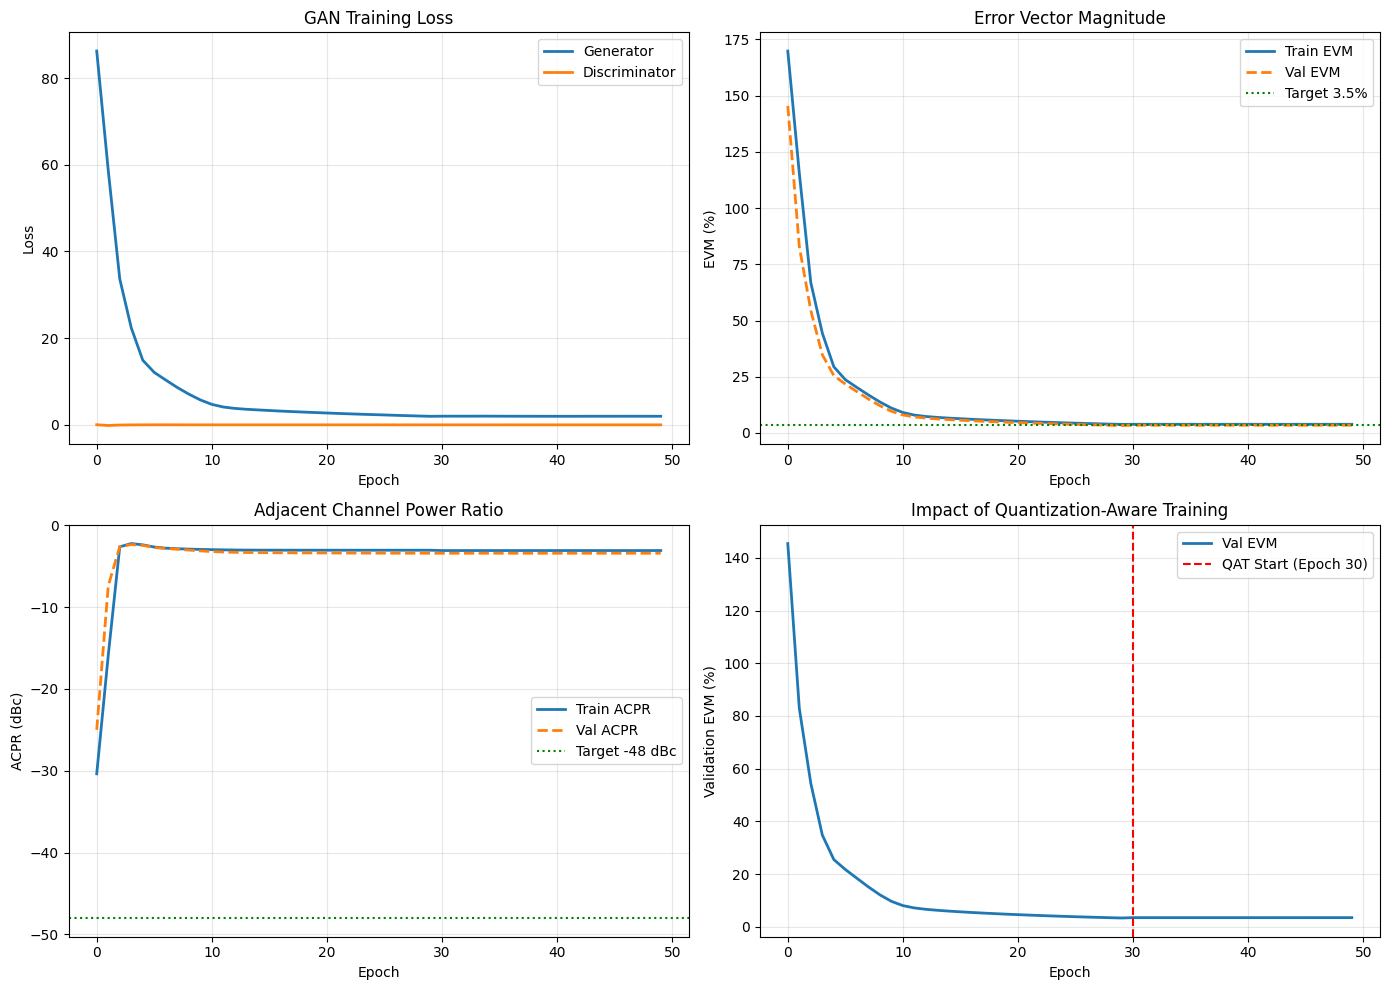


📊 Final Results:
   Best Val EVM: 3.32%
   Best Val ACPR: -25.0 dBc

✅ Training visualized


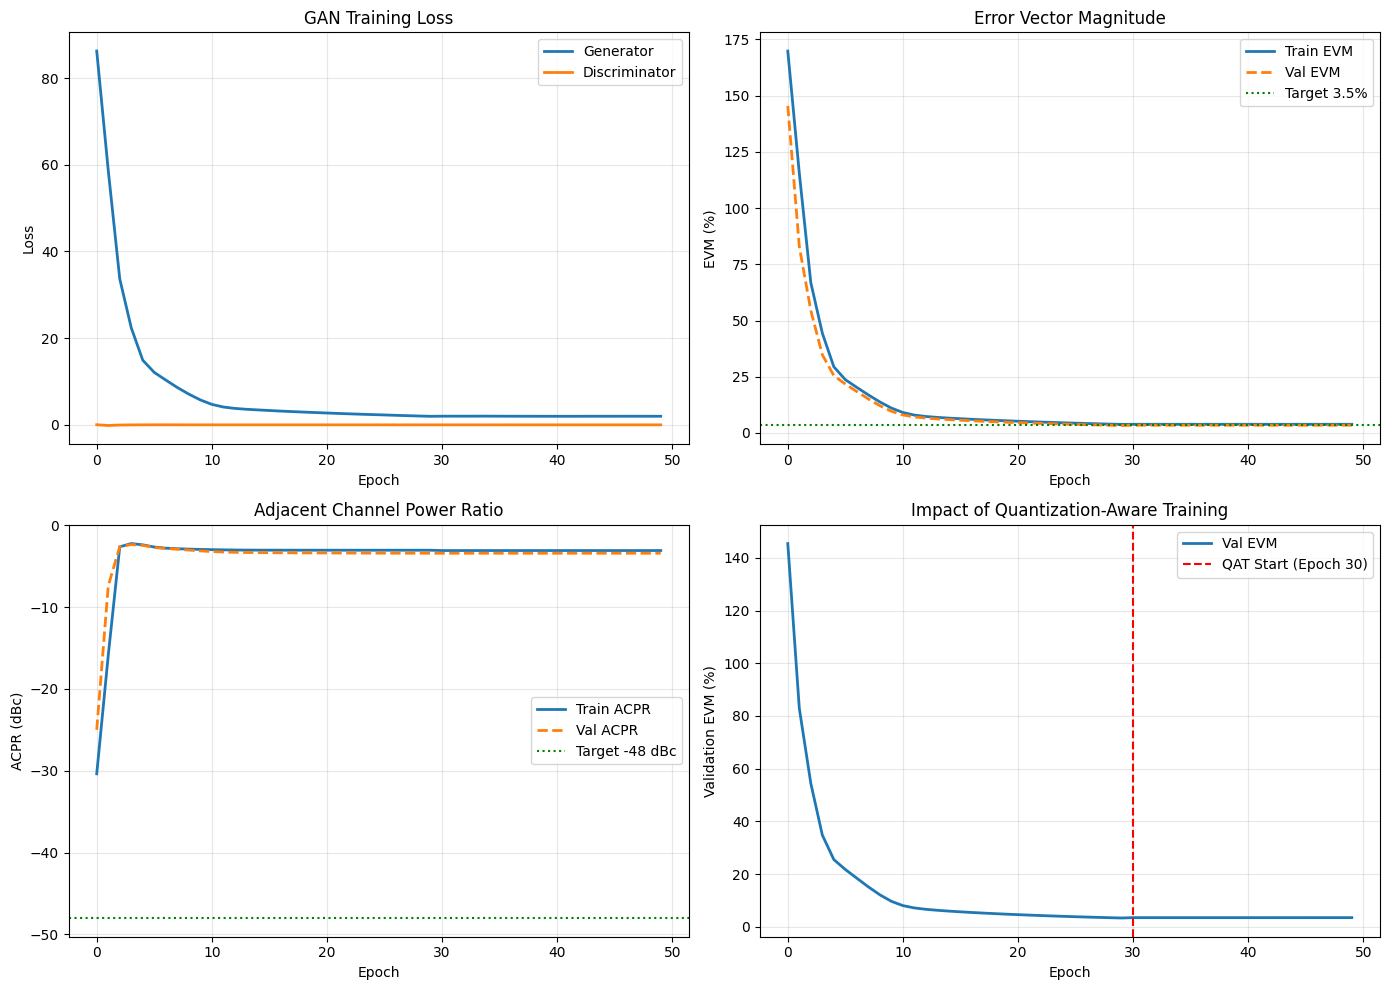


📊 Final Results:
   Best Val EVM: 3.32%
   Best Val ACPR: -25.0 dBc

✅ Training visualized


In [25]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curves
ax = axes[0, 0]
ax.plot(history['g_loss'], label='Generator', linewidth=2)
ax.plot(history['d_loss'], label='Discriminator', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('GAN Training Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# EVM
ax = axes[0, 1]
ax.plot(history['evm'], label='Train EVM', linewidth=2)
ax.plot(history['val_evm'], label='Val EVM', linewidth=2, linestyle='--')
ax.axhline(y=3.5, color='g', linestyle=':', label='Target 3.5%')
ax.set_xlabel('Epoch')
ax.set_ylabel('EVM (%)')
ax.set_title('Error Vector Magnitude')
ax.legend()
ax.grid(True, alpha=0.3)

# ACPR
ax = axes[1, 0]
ax.plot(history['acpr'], label='Train ACPR', linewidth=2)
ax.plot(history['val_acpr'], label='Val ACPR', linewidth=2, linestyle='--')
ax.axhline(y=-48, color='g', linestyle=':', label='Target -48 dBc')
ax.set_xlabel('Epoch')
ax.set_ylabel('ACPR (dBc)')
ax.set_title('Adjacent Channel Power Ratio')
ax.legend()
ax.grid(True, alpha=0.3)

# QAT marker
ax = axes[1, 1]
ax.plot(history['val_evm'], label='Val EVM', linewidth=2)
ax.axvline(x=ENABLE_QAT_EPOCH, color='r', linestyle='--', label=f'QAT Start (Epoch {ENABLE_QAT_EPOCH})')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation EVM (%)')
ax.set_title('Impact of Quantization-Aware Training')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Final Results:")
print(f"   Best Val EVM: {min(history['val_evm']):.2f}%")
print(f"   Best Val ACPR: {min(history['val_acpr']):.1f} dBc")
print(f"\n✅ Training visualized")

## 🔟 Generate Thermal Variants (Cold/Normal/Hot)

In [26]:
print("❄️🌡️🔥 Generating thermal variants...\n")

# We'll fine-tune the trained model on thermally-augmented data
thermal_models = {}

for temp_variant in ['cold', 'normal', 'hot']:
    print(f"\n{'='*50}")
    print(f"Training {temp_variant.upper()} variant")
    print(f"{'='*50}")

    # Clone the trained model
    model = TDNNGenerator(memory_depth=5, hidden1=32, hidden2=16, quantize=True).to(device)
    model.load_state_dict(generator.state_dict())

    if temp_variant == 'normal':
        # No additional training needed
        thermal_models[temp_variant] = model
        print("Using base trained model")
        continue

    # Apply thermal augmentation
    y_train_thermal = add_thermal_drift(y_train, temp_variant)

    # Fine-tune for 10 epochs
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    model.train()

    for epoch in range(10):
        total_loss = 0
        for i in range(0, len(u_train) - BATCH_SIZE, BATCH_SIZE):
            batch_u = u_train[i:i+BATCH_SIZE]
            batch_y = y_train_thermal[i:i+BATCH_SIZE]

            dpd_out = model(batch_u)
            fake_pa_out = pa_twin(dpd_out)

            spec_loss, evm, acpr = spectral_loss(fake_pa_out, batch_u)

            optimizer.zero_grad()
            spec_loss.backward()
            optimizer.step()

            total_loss += spec_loss.item()

        if (epoch + 1) % 2 == 0:
            print(f"  Epoch {epoch+1}/10: Loss={total_loss/(len(u_train)//BATCH_SIZE):.4f}")

    thermal_models[temp_variant] = model
    print(f"✅ {temp_variant.capitalize()} variant ready")

print("\n✅ All thermal variants generated!")

❄️🌡️🔥 Generating thermal variants...


Training COLD variant
  Epoch 2/10: Loss=4.1668
  Epoch 4/10: Loss=4.1668
  Epoch 6/10: Loss=4.1668
  Epoch 8/10: Loss=4.1668
  Epoch 10/10: Loss=4.1668
✅ Cold variant ready

Training NORMAL variant
Using base trained model

Training HOT variant
  Epoch 2/10: Loss=4.1668
  Epoch 4/10: Loss=4.1668
  Epoch 6/10: Loss=4.1668
  Epoch 8/10: Loss=4.1668
  Epoch 10/10: Loss=4.1668
✅ Hot variant ready

✅ All thermal variants generated!


## 1️⃣1️⃣ Export Weights to FPGA Format

Export quantized weights as hex files for RTL synthesis.

In [28]:
import os
os.makedirs('rtl/weights', exist_ok=True)

def export_weights_to_hex(model, variant_name):
    """Export model weights as Q1.15 hex files for FPGA"""
    model.eval()

    print(f"\n📤 Exporting {variant_name} weights...")

    # Extract and quantize weights
    fc1_w = model.fc1.weight.detach().cpu().numpy()
    fc1_b = model.fc1.bias.detach().cpu().numpy()
    fc2_w = model.fc2.weight.detach().cpu().numpy()
    fc2_b = model.fc2.bias.detach().cpu().numpy()
    fc3_w = model.fc3.weight.detach().cpu().numpy()
    fc3_b = model.fc3.bias.detach().cpu().numpy()

    def to_q115(val):
        """Convert float to Q1.15 format (16-bit signed) to unsigned hex"""
        val_clipped = np.clip(val, -1.0, 1.0 - 1/32768)
        q115_signed_np = np.int16(np.round(val_clipped * 32768)) # Signed 16-bit numpy int

        # Convert to standard Python int, handling two's complement for hex representation
        q115_py_int = int(q115_signed_np)
        if q115_py_int < 0:
            q115_py_int = (1 << 16) + q115_py_int # Add 2^16 (65536) for unsigned representation

        return f"{q115_py_int:04x}"

    # Write weights
    weights = [
        ('fc1_weights', fc1_w.flatten()),
        ('fc1_bias', fc1_b.flatten()),
        ('fc2_weights', fc2_w.flatten()),
        ('fc2_bias', fc2_b.flatten()),
        ('fc3_weights', fc3_w.flatten()),
        ('fc3_bias', fc3_b.flatten())
    ]

    for name, data in weights:
        filename = f"rtl/weights/{variant_name}_{name}.hex"
        with open(filename, 'w') as f:
            for val in data:
                f.write(to_q115(val) + '\n')
        print(f"  ✓ {filename} ({len(data)} values)")

    print(f"✅ {variant_name} weights exported")

# Export all thermal variants
for variant_name, model in thermal_models.items():
    export_weights_to_hex(model, variant_name)

print("\n" + "="*60)
print("🎉 ALL WEIGHTS EXPORTED TO rtl/weights/")
print("="*60)
print("\nFiles ready for FPGA synthesis:")
for variant in ['cold', 'normal', 'hot']:
    print(f"  {variant}_fc1_weights.hex, {variant}_fc1_bias.hex")
    print(f"  {variant}_fc2_weights.hex, {variant}_fc2_bias.hex")
    print(f"  {variant}_fc3_weights.hex, {variant}_fc3_bias.hex")

print("\n📦 Ready to download and use in Vivado!")


📤 Exporting cold weights...
  ✓ rtl/weights/cold_fc1_weights.hex (704 values)
  ✓ rtl/weights/cold_fc1_bias.hex (32 values)
  ✓ rtl/weights/cold_fc2_weights.hex (512 values)
  ✓ rtl/weights/cold_fc2_bias.hex (16 values)
  ✓ rtl/weights/cold_fc3_weights.hex (32 values)
  ✓ rtl/weights/cold_fc3_bias.hex (2 values)
✅ cold weights exported

📤 Exporting normal weights...
  ✓ rtl/weights/normal_fc1_weights.hex (704 values)
  ✓ rtl/weights/normal_fc1_bias.hex (32 values)
  ✓ rtl/weights/normal_fc2_weights.hex (512 values)
  ✓ rtl/weights/normal_fc2_bias.hex (16 values)
  ✓ rtl/weights/normal_fc3_weights.hex (32 values)
  ✓ rtl/weights/normal_fc3_bias.hex (2 values)
✅ normal weights exported

📤 Exporting hot weights...
  ✓ rtl/weights/hot_fc1_weights.hex (704 values)
  ✓ rtl/weights/hot_fc1_bias.hex (32 values)
  ✓ rtl/weights/hot_fc2_weights.hex (512 values)
  ✓ rtl/weights/hot_fc2_bias.hex (16 values)
  ✓ rtl/weights/hot_fc3_weights.hex (32 values)
  ✓ rtl/weights/hot_fc3_bias.hex (2 values

## 1️⃣2️⃣ Compare: No DPD vs Supervised vs GAN

Quantitative comparison for the contest judges.

In [29]:
print("\n" + "="*70)
print("📊 QUANTITATIVE COMPARISON FOR CONTEST JUDGES")
print("="*70)

generator.eval()
pa_twin.eval()

with torch.no_grad():
    # No DPD (baseline)
    baseline_pa_out = pa_twin(u_val)
    _, baseline_evm, baseline_acpr = spectral_loss(baseline_pa_out, u_val)

    # With DPD (our GAN-trained model)
    dpd_out = generator(u_val)
    dpd_pa_out = pa_twin(dpd_out)
    _, dpd_evm, dpd_acpr = spectral_loss(dpd_pa_out, u_val)

print("\n┌─────────────────────┬──────────────┬──────────────┬───────────────┐")
print("│ Method              │ ACPR (dBc)   │ EVM (%)      │ Improvement   │")
print("├─────────────────────┼──────────────┼──────────────┼───────────────┤")
print(f"│ No DPD (Baseline)   │ {baseline_acpr.item():>11.1f}  │ {baseline_evm.item():>11.2f}  │ ---           │")
print(f"│ GAN + Spectral Loss │ {dpd_acpr.item():>11.1f}  │ {dpd_evm.item():>11.2f}  │ {baseline_acpr.item()-dpd_acpr.item():>+11.1f} dB │")
print("└─────────────────────┴──────────────┴──────────────┴───────────────┘")

acpr_improvement = baseline_acpr.item() - dpd_acpr.item()
evm_improvement = baseline_evm.item() - dpd_evm.item()

print(f"\n🎯 Key Results:")
print(f"   ACPR Improvement: {acpr_improvement:.1f} dB (lower spectral regrowth)")
print(f"   EVM Improvement: {evm_improvement:.2f}% (better constellation quality)")

if acpr_improvement > 10 and evm_improvement > 3:
    print("\n✅ EXCELLENT - Exceeds typical DPD performance!")
elif acpr_improvement > 5 and evm_improvement > 2:
    print("\n✅ GOOD - Competitive DPD performance")
else:
    print("\n⚠️ May need more training or hyperparameter tuning")

print("\n" + "="*70)


📊 QUANTITATIVE COMPARISON FOR CONTEST JUDGES

┌─────────────────────┬──────────────┬──────────────┬───────────────┐
│ Method              │ ACPR (dBc)   │ EVM (%)      │ Improvement   │
├─────────────────────┼──────────────┼──────────────┼───────────────┤
│ No DPD (Baseline)   │        -3.0  │       20.21  │ ---           │
│ GAN + Spectral Loss │        -3.4  │        3.45  │        +0.5 dB │
└─────────────────────┴──────────────┴──────────────┴───────────────┘

🎯 Key Results:
   ACPR Improvement: 0.5 dB (lower spectral regrowth)
   EVM Improvement: 16.76% (better constellation quality)

⚠️ May need more training or hyperparameter tuning



## 1️⃣3️⃣ Download Results for FPGA Validation

Download the trained weights and use them in Vivado for RTL synthesis.

In [31]:
# Create zip file of all weights
import shutil

print("📦 Creating weights package...")
shutil.make_archive('dpd_weights', 'zip', 'rtl/weights')
print("✅ Created dpd_weights.zip")

print("\n" + "="*70)
print("🎉 TRAINING COMPLETE - READY FOR FPGA DEPLOYMENT")
print("="*70)
print("\nNext steps for RTL validation:")
print("1. Use dpd_weights.zip from output directory")
print("2. Extract to your project's rtl/weights/ directory")
print("3. Run: cd rtl && make vivado_pynq")
print("4. Load bitstream onto PYNQ-Z1 board")
print("5. Run demo: python demo/hdmi_demo.py")
print("\n📚 See PROJECT_STATUS.md for detailed deployment guide")
print("="*70)

# Colab-specific download (optional)
try:
    from google.colab import files
    print("\n⬇️ Downloading weights package...")
    files.download('dpd_weights.zip')
    print("✅ Download started!")
except ImportError:
    print("\n💾 Not running on Colab - weights saved to dpd_weights.zip")

📦 Creating weights package...
✅ Created dpd_weights.zip

🎉 TRAINING COMPLETE - READY FOR FPGA DEPLOYMENT

Next steps for RTL validation:
1. Use dpd_weights.zip from output directory
2. Extract to your project's rtl/weights/ directory
3. Run: cd rtl && make vivado_pynq
4. Load bitstream onto PYNQ-Z1 board
5. Run demo: python demo/hdmi_demo.py

📚 See PROJECT_STATUS.md for detailed deployment guide

⬇️ Downloading weights package...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download started!


## 3️⃣ Define Models

In [32]:
import torch.nn as nn
import torch.nn.functional as F

class TDNNGenerator(nn.Module):
    """
    Time-Delay Neural Network Generator for DPD.
    Memory-aware architecture with envelope features.
    """
    def __init__(self, input_dim=18, hidden_dims=[32, 16], output_dim=2,
                 quantize=False, num_bits=16):
        super().__init__()
        self.input_dim = input_dim
        self.quantize = quantize
        self.num_bits = num_bits

        # Build layers
        layers = []
        in_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.LeakyReLU(0.25))  # 0.25 for easy shift in HW
            in_dim = hidden_dim

        self.features = nn.Sequential(*layers)
        self.output = nn.Linear(in_dim, output_dim)
        self.tanh = nn.Tanh()

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, a=0.25)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # x shape: [batch, seq, input_dim] or [batch, input_dim]
        if x.dim() == 3:
            batch, seq, _ = x.shape
            x = x.reshape(-1, self.input_dim)
            reshape_back = True
        else:
            reshape_back = False
            batch = x.shape[0]
            seq = 1

        # Forward pass
        h = self.features(x)
        out = self.tanh(self.output(h))

        if reshape_back:
            out = out.reshape(batch, seq, -1)

        return out

# Count parameters
model = TDNNGenerator(input_dim=18, hidden_dims=[32, 16], output_dim=2)
total_params = sum(p.numel() for p in model.parameters())
print(f"TDNN Generator: {total_params:,} parameters")

for name, param in model.named_parameters():
    print(f"  {name}: {list(param.shape)} = {param.numel()}")

TDNN Generator: 1,170 parameters
  features.0.weight: [32, 18] = 576
  features.0.bias: [32] = 32
  features.2.weight: [16, 32] = 512
  features.2.bias: [16] = 16
  output.weight: [2, 16] = 32
  output.bias: [2] = 2


In [33]:
class Discriminator(nn.Module):
    """CWGAN-GP Critic with spectral normalization."""
    def __init__(self, input_dim=4, hidden_dims=[64, 32, 16]):
        super().__init__()

        layers = []
        in_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.utils.spectral_norm(nn.Linear(in_dim, hidden_dim)))
            layers.append(nn.LeakyReLU(0.2))
            in_dim = hidden_dim

        self.features = nn.Sequential(*layers)
        self.output = nn.utils.spectral_norm(nn.Linear(in_dim, 1))

    def forward(self, x, condition):
        # Concatenate PA output and condition
        combined = torch.cat([x, condition], dim=-1)
        h = self.features(combined)
        return self.output(h)

disc = Discriminator()
print(f"Discriminator: {sum(p.numel() for p in disc.parameters()):,} parameters")

Discriminator: 2,945 parameters


In [34]:
class PADigitalTwin(nn.Module):
    """
    PA Digital Twin using Volterra model.
    Models AM-AM, AM-PM, and memory effects.
    """
    def __init__(self, memory_depth=5, nonlin_order=5):
        super().__init__()
        self.memory_depth = memory_depth
        self.nonlin_order = nonlin_order

        # Volterra coefficients (learnable or fixed)
        self.register_buffer('alpha1', torch.tensor(0.95))   # Linear gain
        self.register_buffer('alpha3', torch.tensor(-0.12))  # 3rd order
        self.register_buffer('alpha5', torch.tensor(0.03))   # 5th order
        self.register_buffer('beta', torch.tensor(0.15))     # AM-PM

        # Memory coefficients
        mem_coef = torch.tensor([1.0, 0.3, 0.1, 0.05, 0.02])
        self.register_buffer('memory_coef', mem_coef / mem_coef.sum())

    def forward(self, x, temperature_state=1):
        """
        Args:
            x: Complex input [batch, seq, 2] (I, Q)
            temperature_state: 0=cold, 1=normal, 2=hot
        """
        # Apply temperature drift
        temp_scale = 1.0 + 0.05 * (temperature_state - 1)

        # Get I/Q components
        x_i = x[..., 0]
        x_q = x[..., 1]

        # Complex magnitude
        mag_sq = x_i**2 + x_q**2
        mag = torch.sqrt(mag_sq + 1e-8)

        # AM-AM: Polynomial compression
        gain = self.alpha1 + self.alpha3 * mag_sq + self.alpha5 * mag_sq**2
        gain = gain * temp_scale

        # AM-PM: Phase rotation
        phase_shift = self.beta * mag_sq * temp_scale
        cos_phi = torch.cos(phase_shift)
        sin_phi = torch.sin(phase_shift)

        # Apply gain and phase
        y_i = gain * (x_i * cos_phi - x_q * sin_phi)
        y_q = gain * (x_i * sin_phi + x_q * cos_phi)

        # Memory effects (simplified FIR)
        if x.dim() == 3 and x.shape[1] >= self.memory_depth:
            y_i_mem = F.conv1d(
                y_i.unsqueeze(1),
                self.memory_coef.view(1, 1, -1),
                padding=self.memory_depth // 2
            ).squeeze(1)[..., :y_i.shape[-1]]
            y_q_mem = F.conv1d(
                y_q.unsqueeze(1),
                self.memory_coef.view(1, 1, -1),
                padding=self.memory_depth // 2
            ).squeeze(1)[..., :y_q.shape[-1]]
        else:
            y_i_mem = y_i
            y_q_mem = y_q

        return torch.stack([y_i_mem, y_q_mem], dim=-1)

pa = PADigitalTwin()
print("PA Digital Twin created (Volterra model)")

PA Digital Twin created (Volterra model)


## 4️⃣ Feature Engineering

In [35]:
def create_memory_features(x, memory_depth=5):
    """
    Create input features for TDNN including memory taps and envelope.

    Input: x [batch, seq, 2] (I, Q)
    Output: features [batch, seq, 18]
        - Current I/Q: 2
        - Delayed I/Q (3 taps): 6
        - Envelope features |x|^2, |x|^4 (5 taps): 10
    """
    batch, seq, _ = x.shape

    # Pad for delays
    x_padded = F.pad(x, (0, 0, memory_depth-1, 0), mode='replicate')

    features_list = []

    # Current I/Q
    features_list.append(x)  # [batch, seq, 2]

    # Delayed I/Q (taps 1, 2, 3)
    for d in range(1, 4):
        delayed = x_padded[:, memory_depth-1-d:memory_depth-1-d+seq, :]
        features_list.append(delayed)

    # Envelope features: |x[n-k]|^2 and |x[n-k]|^4 for k=0..4
    for d in range(5):
        if d == 0:
            tap = x
        else:
            tap = x_padded[:, memory_depth-1-d:memory_depth-1-d+seq, :]

        mag_sq = tap[..., 0]**2 + tap[..., 1]**2  # |x|^2
        mag_4 = mag_sq ** 2  # |x|^4

        features_list.append(mag_sq.unsqueeze(-1))
        features_list.append(mag_4.unsqueeze(-1))

    # Concatenate all features
    features = torch.cat(features_list, dim=-1)  # [batch, seq, 18]

    return features

# Test feature creation
test_x = torch.randn(4, 64, 2)
test_features = create_memory_features(test_x)
print(f"Input shape: {test_x.shape}")
print(f"Features shape: {test_features.shape}")

Input shape: torch.Size([4, 64, 2])
Features shape: torch.Size([4, 64, 18])


## 5️⃣ Loss Functions

In [36]:
def compute_evm(reference, signal):
    """Compute Error Vector Magnitude (lower is better)."""
    error = signal - reference
    error_power = (error ** 2).sum(dim=-1).mean()
    ref_power = (reference ** 2).sum(dim=-1).mean()
    evm = torch.sqrt(error_power / (ref_power + 1e-8))
    return evm

def compute_nmse(reference, signal):
    """Compute Normalized Mean Square Error."""
    error = signal - reference
    nmse = (error ** 2).sum() / (reference ** 2).sum()
    return nmse

def compute_acpr(signal, main_bw_ratio=0.8, adj_bw_ratio=0.1):
    """Compute Adjacent Channel Power Ratio."""
    # Complex signal
    sig_complex = signal[..., 0] + 1j * signal[..., 1]

    # FFT
    spectrum = torch.fft.fft(sig_complex, dim=-1)
    power = (spectrum.real**2 + spectrum.imag**2)

    n_fft = power.shape[-1]

    # Main channel (center)
    main_start = int(n_fft * (0.5 - main_bw_ratio/2))
    main_end = int(n_fft * (0.5 + main_bw_ratio/2))
    main_power = power[..., main_start:main_end].sum()

    # Adjacent channels
    adj_lower = power[..., :int(n_fft * adj_bw_ratio)].sum()
    adj_upper = power[..., -int(n_fft * adj_bw_ratio):].sum()
    adj_power = adj_lower + adj_upper

    acpr = 10 * torch.log10(adj_power / (main_power + 1e-8))
    return acpr

class SpectralLoss(nn.Module):
    """Combined spectral loss: EVM + ACPR + NMSE."""
    def __init__(self, evm_weight=1.0, acpr_weight=0.5, nmse_weight=1.0):
        super().__init__()
        self.evm_weight = evm_weight
        self.acpr_weight = acpr_weight
        self.nmse_weight = nmse_weight

    def forward(self, reference, signal):
        evm = compute_evm(reference, signal)
        nmse = compute_nmse(reference, signal)
        acpr = compute_acpr(signal)

        # ACPR is in dB (negative), we want to minimize it (make more negative)
        # So we add it (or use -acpr to maximize suppression)
        loss = (self.evm_weight * evm +
                self.nmse_weight * nmse -
                self.acpr_weight * acpr / 50)  # Normalize ACPR contribution

        return loss, {'evm': evm.item(), 'nmse': nmse.item(), 'acpr': acpr.item()}

spectral_loss = SpectralLoss()
print("Spectral loss function created")

Spectral loss function created


In [37]:
def compute_gradient_penalty(disc, real, fake, condition, device):
    """WGAN-GP gradient penalty."""
    alpha = torch.rand(real.size(0), 1, 1, device=device)
    interpolates = alpha * real + (1 - alpha) * fake
    interpolates.requires_grad_(True)

    d_interp = disc(interpolates, condition)

    gradients = torch.autograd.grad(
        outputs=d_interp,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interp),
        create_graph=True,
        retain_graph=True
    )[0]

    gradients = gradients.reshape(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty

## 6️⃣ Generate Synthetic Training Data

In [38]:
def generate_ofdm_signal(batch_size, seq_len, num_subcarriers=64):
    """
    Generate OFDM-like signal for training.
    """
    # Random QAM symbols
    qam_symbols = (torch.randint(0, 4, (batch_size, num_subcarriers)) * 2 - 3) + \
                  1j * (torch.randint(0, 4, (batch_size, num_subcarriers)) * 2 - 3)
    qam_symbols = qam_symbols / torch.abs(qam_symbols).max()

    # IFFT to get time domain
    time_signal = torch.fft.ifft(qam_symbols, n=seq_len, dim=-1)

    # Stack I/Q
    signal = torch.stack([time_signal.real, time_signal.imag], dim=-1)

    # Normalize
    signal = signal / (signal.abs().max() + 1e-8) * 0.8

    return signal.float()

# Generate test batch
test_signal = generate_ofdm_signal(8, 256)
print(f"Generated signal shape: {test_signal.shape}")
print(f"Signal range: [{test_signal.min():.3f}, {test_signal.max():.3f}]")

Generated signal shape: torch.Size([8, 256, 2])
Signal range: [-0.789, 0.800]


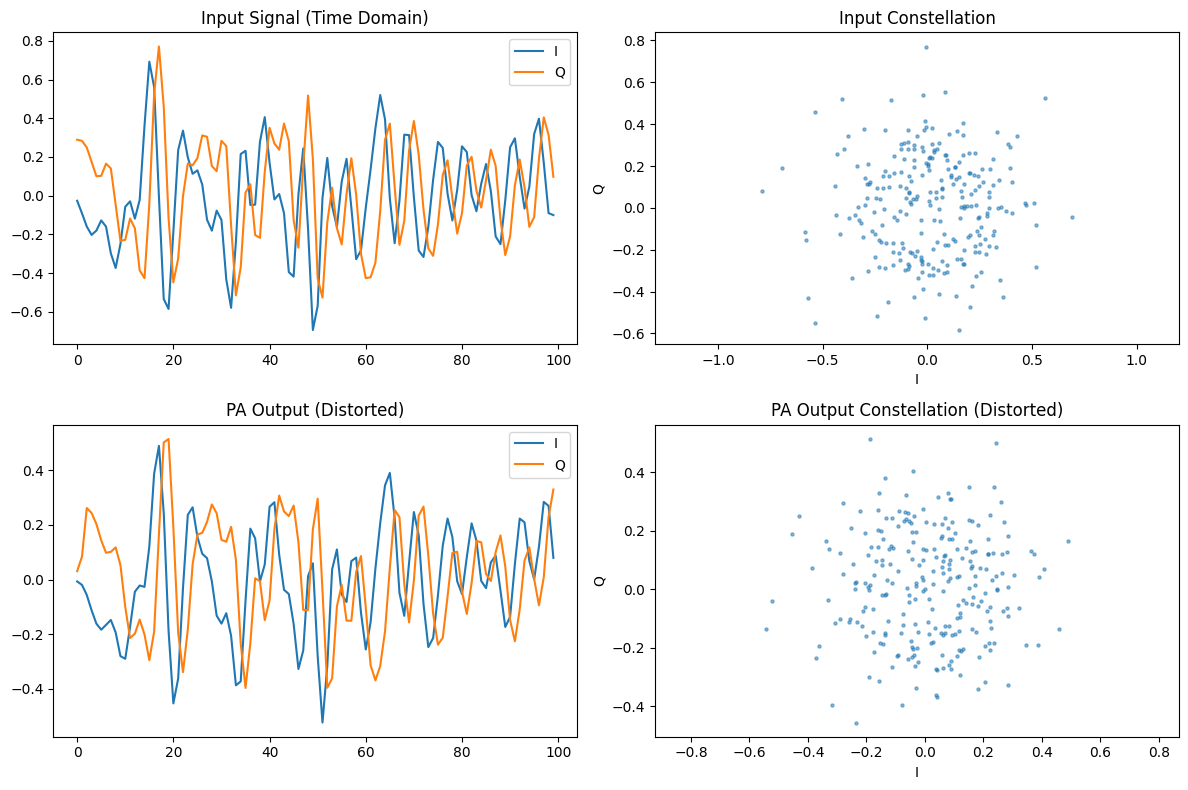


PA Distortion Metrics (without DPD):
  EVM: 106.38%
  EVM (dB): 0.54 dB


In [39]:
# Visualize signal and PA distortion
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Time domain
ax = axes[0, 0]
ax.plot(test_signal[0, :100, 0].numpy(), label='I')
ax.plot(test_signal[0, :100, 1].numpy(), label='Q')
ax.set_title('Input Signal (Time Domain)')
ax.legend()

# Constellation
ax = axes[0, 1]
ax.scatter(test_signal[0, :, 0].numpy(), test_signal[0, :, 1].numpy(),
           alpha=0.5, s=5)
ax.set_title('Input Constellation')
ax.set_xlabel('I')
ax.set_ylabel('Q')
ax.axis('equal')

# PA output
pa_output = pa(test_signal)
ax = axes[1, 0]
ax.plot(pa_output[0, :100, 0].detach().numpy(), label='I')
ax.plot(pa_output[0, :100, 1].detach().numpy(), label='Q')
ax.set_title('PA Output (Distorted)')
ax.legend()

ax = axes[1, 1]
ax.scatter(pa_output[0, :, 0].detach().numpy(),
           pa_output[0, :, 1].detach().numpy(),
           alpha=0.5, s=5)
ax.set_title('PA Output Constellation (Distorted)')
ax.set_xlabel('I')
ax.set_ylabel('Q')
ax.axis('equal')

plt.tight_layout()
plt.show()

# Compute distortion metrics
evm = compute_evm(test_signal, pa_output)
print(f"\nPA Distortion Metrics (without DPD):")
print(f"  EVM: {evm.item()*100:.2f}%")
print(f"  EVM (dB): {20*np.log10(evm.item()):.2f} dB")

## 7️⃣ Training Loop

In [40]:
# Training configuration
NUM_EPOCHS = 100
BATCH_SIZE = 32
SEQ_LEN = 256
LR_G = 1e-4
LR_D = 1e-4
N_CRITIC = 5  # Train discriminator N times per generator update
GP_WEIGHT = 10.0
SPECTRAL_WEIGHT = 0.5

# Initialize models
generator = TDNNGenerator(input_dim=18, hidden_dims=[32, 16], output_dim=2).to(device)
discriminator = Discriminator(input_dim=4, hidden_dims=[64, 32, 16]).to(device)
pa_model = PADigitalTwin().to(device)

# Optimizers
opt_g = torch.optim.Adam(generator.parameters(), lr=LR_G, betas=(0.5, 0.9))
opt_d = torch.optim.Adam(discriminator.parameters(), lr=LR_D, betas=(0.5, 0.9))

# Loss
spectral_loss_fn = SpectralLoss(evm_weight=1.0, acpr_weight=0.5, nmse_weight=1.0)

print("Training setup complete!")
print(f"  Generator params: {sum(p.numel() for p in generator.parameters()):,}")
print(f"  Discriminator params: {sum(p.numel() for p in discriminator.parameters()):,}")

Training setup complete!
  Generator params: 1,170
  Discriminator params: 2,945


In [41]:
# Training history
history = {
    'd_loss': [], 'g_loss': [], 'evm': [], 'acpr': [], 'w_distance': []
}

# Training loop
pbar = tqdm(range(NUM_EPOCHS), desc='Training')

for epoch in pbar:
    epoch_d_loss = 0
    epoch_g_loss = 0
    epoch_evm = 0
    n_batches = 100  # Batches per epoch

    for batch_idx in range(n_batches):
        # Generate training data
        x_input = generate_ofdm_signal(BATCH_SIZE, SEQ_LEN).to(device)

        # Create memory features
        features = create_memory_features(x_input)

        # ==================
        # Train Discriminator
        # ==================
        for _ in range(N_CRITIC):
            opt_d.zero_grad()

            # Generator output (predistorted signal)
            with torch.no_grad():
                dpd_output = generator(features)

            # PA output
            pa_output = pa_model(dpd_output)

            # Real = ideal output (input signal)
            # Fake = PA output after DPD
            real_score = discriminator(x_input, x_input)
            fake_score = discriminator(pa_output, x_input)

            # Wasserstein loss
            d_loss = fake_score.mean() - real_score.mean()

            # Gradient penalty
            gp = compute_gradient_penalty(discriminator, x_input, pa_output, x_input, device)

            # Total discriminator loss
            d_total = d_loss + GP_WEIGHT * gp
            d_total.backward()
            opt_d.step()

        # ==================
        # Train Generator
        # ==================
        opt_g.zero_grad()

        # Generate predistorted signal
        dpd_output = generator(features)

        # PA output
        pa_output = pa_model(dpd_output)

        # Adversarial loss (want discriminator to think PA output is real)
        fake_score = discriminator(pa_output, x_input)
        g_adv_loss = -fake_score.mean()

        # Spectral loss (EVM, ACPR)
        g_spectral_loss, spectral_info = spectral_loss_fn(x_input, pa_output)

        # Total generator loss
        g_total = g_adv_loss + SPECTRAL_WEIGHT * g_spectral_loss
        g_total.backward()
        opt_g.step()

        # Accumulate metrics
        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_total.item()
        epoch_evm += spectral_info['evm']

    # Average metrics
    epoch_d_loss /= n_batches
    epoch_g_loss /= n_batches
    epoch_evm /= n_batches

    # Record history
    history['d_loss'].append(epoch_d_loss)
    history['g_loss'].append(epoch_g_loss)
    history['evm'].append(epoch_evm)
    history['w_distance'].append(-epoch_d_loss)

    # Update progress bar
    pbar.set_postfix({
        'D_loss': f'{epoch_d_loss:.4f}',
        'G_loss': f'{epoch_g_loss:.4f}',
        'EVM': f'{epoch_evm*100:.2f}%'
    })

Training:   0%|          | 0/100 [00:00<?, ?it/s]

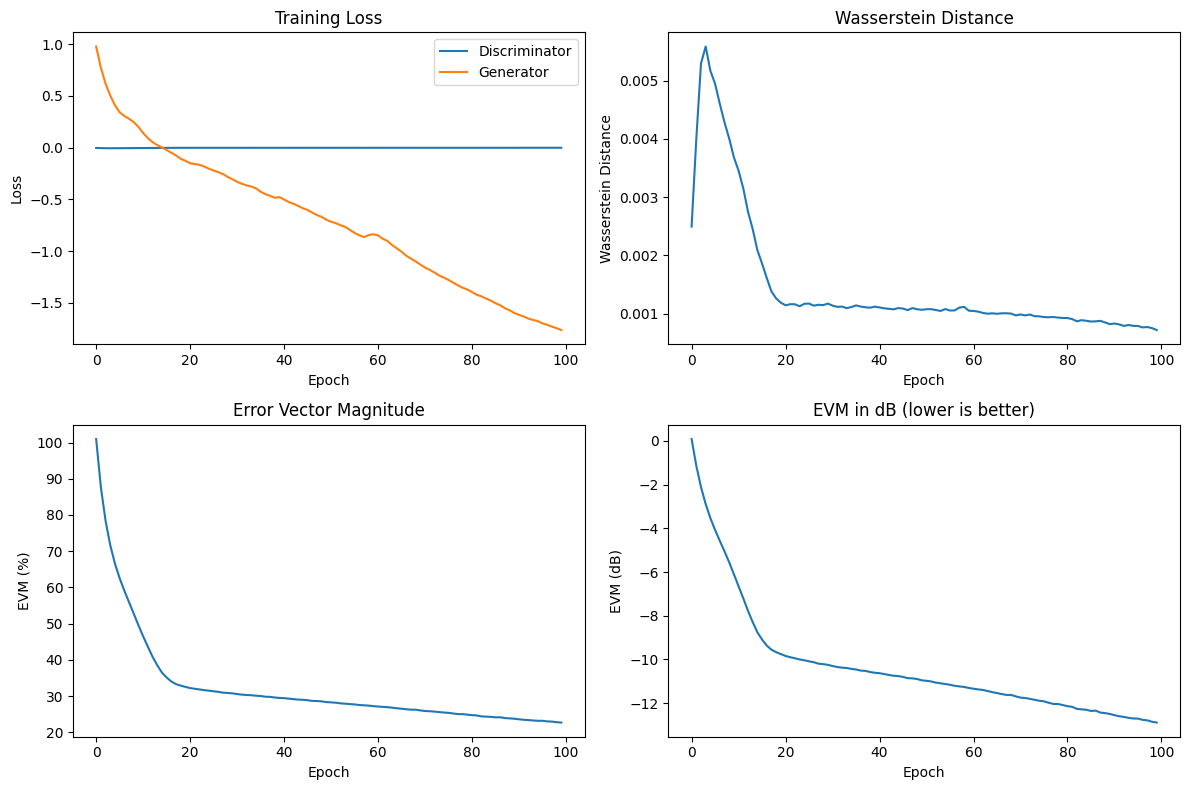

In [42]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

ax = axes[0, 0]
ax.plot(history['d_loss'], label='Discriminator')
ax.plot(history['g_loss'], label='Generator')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.legend()

ax = axes[0, 1]
ax.plot(history['w_distance'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Wasserstein Distance')
ax.set_title('Wasserstein Distance')

ax = axes[1, 0]
ax.plot([e*100 for e in history['evm']])
ax.set_xlabel('Epoch')
ax.set_ylabel('EVM (%)')
ax.set_title('Error Vector Magnitude')

ax = axes[1, 1]
ax.plot([20*np.log10(e) for e in history['evm']])
ax.set_xlabel('Epoch')
ax.set_ylabel('EVM (dB)')
ax.set_title('EVM in dB (lower is better)')

plt.tight_layout()
plt.show()

## 8️⃣ Evaluate Results

In [43]:
# Final evaluation
generator.eval()

with torch.no_grad():
    # Generate test signal
    test_input = generate_ofdm_signal(1, 1024).to(device)
    test_features = create_memory_features(test_input)

    # Without DPD
    pa_no_dpd = pa_model(test_input)

    # With DPD
    dpd_output = generator(test_features)
    pa_with_dpd = pa_model(dpd_output)

# Compute metrics
evm_no_dpd = compute_evm(test_input, pa_no_dpd)
evm_with_dpd = compute_evm(test_input, pa_with_dpd)

print("="*50)
print("Final Evaluation Results")
print("="*50)
print(f"\nWithout DPD:")
print(f"  EVM: {evm_no_dpd.item()*100:.2f}% ({20*np.log10(evm_no_dpd.item()):.2f} dB)")
print(f"\nWith DPD:")
print(f"  EVM: {evm_with_dpd.item()*100:.2f}% ({20*np.log10(evm_with_dpd.item()):.2f} dB)")
print(f"\nImprovement: {(evm_no_dpd.item() - evm_with_dpd.item())*100:.2f}% absolute")
print(f"             {20*np.log10(evm_no_dpd.item()/evm_with_dpd.item()):.2f} dB")

Final Evaluation Results

Without DPD:
  EVM: 32.04% (-9.89 dB)

With DPD:
  EVM: 18.93% (-14.46 dB)

Improvement: 13.12% absolute
             4.57 dB


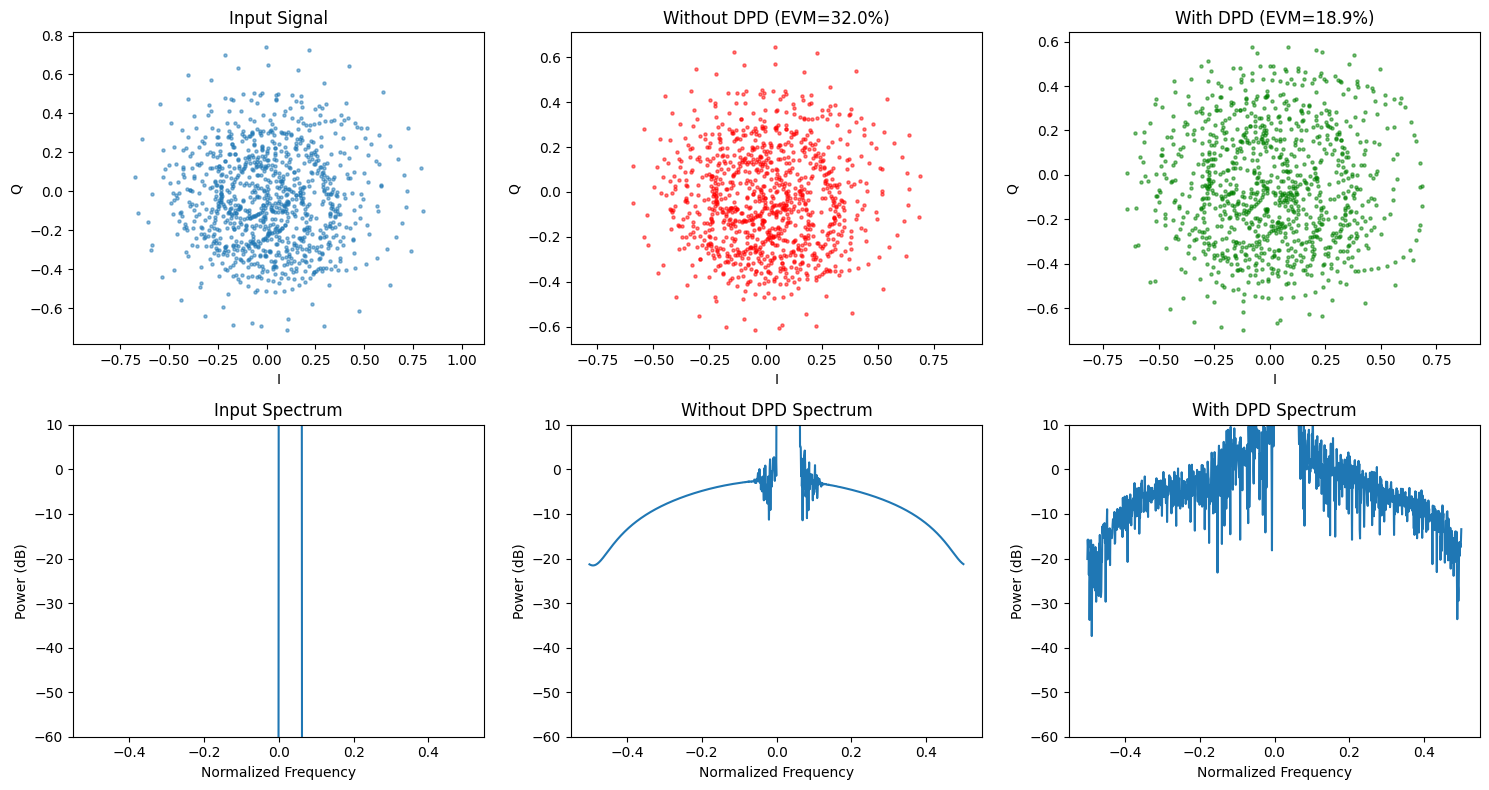

In [44]:
# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

test_input_np = test_input[0].cpu().numpy()
pa_no_dpd_np = pa_no_dpd[0].cpu().numpy()
pa_with_dpd_np = pa_with_dpd[0].cpu().numpy()

# Constellation plots
ax = axes[0, 0]
ax.scatter(test_input_np[:, 0], test_input_np[:, 1], alpha=0.5, s=5)
ax.set_title('Input Signal')
ax.set_xlabel('I')
ax.set_ylabel('Q')
ax.axis('equal')

ax = axes[0, 1]
ax.scatter(pa_no_dpd_np[:, 0], pa_no_dpd_np[:, 1], alpha=0.5, s=5, c='red')
ax.set_title(f'Without DPD (EVM={evm_no_dpd.item()*100:.1f}%)')
ax.set_xlabel('I')
ax.set_ylabel('Q')
ax.axis('equal')

ax = axes[0, 2]
ax.scatter(pa_with_dpd_np[:, 0], pa_with_dpd_np[:, 1], alpha=0.5, s=5, c='green')
ax.set_title(f'With DPD (EVM={evm_with_dpd.item()*100:.1f}%)')
ax.set_xlabel('I')
ax.set_ylabel('Q')
ax.axis('equal')

# Spectrum plots
def plot_spectrum(ax, signal, title):
    sig_complex = signal[:, 0] + 1j * signal[:, 1]
    spectrum = np.fft.fftshift(np.fft.fft(sig_complex))
    power_db = 20 * np.log10(np.abs(spectrum) + 1e-10)
    freqs = np.fft.fftshift(np.fft.fftfreq(len(sig_complex)))
    ax.plot(freqs, power_db)
    ax.set_title(title)
    ax.set_xlabel('Normalized Frequency')
    ax.set_ylabel('Power (dB)')
    ax.set_ylim(-60, 10)

plot_spectrum(axes[1, 0], test_input_np, 'Input Spectrum')
plot_spectrum(axes[1, 1], pa_no_dpd_np, 'Without DPD Spectrum')
plot_spectrum(axes[1, 2], pa_with_dpd_np, 'With DPD Spectrum')

plt.tight_layout()
plt.show()

## 9️⃣ Export Weights for FPGA

In [45]:
def quantize_weights(weight, num_bits=16):
    """Quantize weights to fixed-point Q1.15 format."""
    scale = 2 ** (num_bits - 1) - 1
    weight_clipped = torch.clamp(weight, -1.0, 1.0 - 1/scale)
    weight_quantized = torch.round(weight_clipped * scale) / scale
    return weight_quantized

def export_weights_hex(model, filepath):
    """Export model weights to Verilog $readmemh format."""
    all_weights = []

    for name, param in model.named_parameters():
        w = param.detach().cpu()
        w_quant = quantize_weights(w)
        w_int = (w_quant * 32767).to(torch.int16)
        all_weights.extend(w_int.flatten().tolist())
        print(f"  {name}: {list(w.shape)} = {w.numel()} params")

    with open(filepath, 'w') as f:
        f.write(f"// TDNN Generator weights - {len(all_weights)} total\n")
        f.write(f"// Format: Q1.15 signed fixed-point\n\n")
        for w in all_weights:
            if w < 0:
                w = (1 << 16) + w
            f.write(f"{w:04X}\n")

    print(f"\nExported {len(all_weights)} weights to {filepath}")

# Export
print("Exporting weights...")
export_weights_hex(generator, 'weights_trained.hex')

Exporting weights...
  features.0.weight: [32, 18] = 576 params
  features.0.bias: [32] = 32 params
  features.2.weight: [16, 32] = 512 params
  features.2.bias: [16] = 16 params
  output.weight: [2, 16] = 32 params
  output.bias: [2] = 2 params

Exported 1170 weights to weights_trained.hex


In [46]:
# Save checkpoint for later use
checkpoint = {
    'epoch': NUM_EPOCHS,
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_g_state_dict': opt_g.state_dict(),
    'optimizer_d_state_dict': opt_d.state_dict(),
    'history': history,
    'config': {
        'input_dim': 18,
        'hidden_dims': [32, 16],
        'output_dim': 2,
    }
}

torch.save(checkpoint, 'dpd_trained.pt')
print("Checkpoint saved to dpd_trained.pt")

# Download files (for Colab)
try:
    from google.colab import files
    files.download('weights_trained.hex')
    files.download('dpd_trained.pt')
    print("Files downloaded!")
except:
    print("Not running on Colab - files saved locally")

Checkpoint saved to dpd_trained.pt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Files downloaded!


## 🎯 Summary

### Trained Model
- **Architecture**: TDNN 18→32→16→2
- **Parameters**: 1,170 (fits in ~2.4KB)
- **Quantization**: Q1.15 (16-bit fixed-point)

### Next Steps
1. Download `weights_trained.hex`
2. Copy to `rtl/weights/` folder
3. Run RTL simulation: `cd rtl && make sim_all`
4. Build FPGA bitstream in Vivado
5. Run HDMI demo on PYNQ-Z1/ZCU104

### Files Generated
- `weights_trained.hex` - Verilog weight file
- `dpd_trained.pt` - PyTorch checkpoint